# Cylindrical CNN for Beer Cap Classification
In this notebook, we try to develop a **Convolution Neural Network** that can classify randomly rotated beer caps while training on limited data. We do this by trying to make the network **invariant to rotation** to reduce the amount of samples needed for training. Our thought behind this is that a network that inherently comprehends rotation will need less training data to obtain reasonable results than a traditional CNN that needs to learn the rotations. To achieve this invariance, we implement the theory published in the paper [CyCNN: A Rotation Invariant CNN using Polar Mapping and Cylindrical Convolution Layers](https://arxiv.org/pdf/2007.10588.pdf). First we apply the theory to the MNIST dataset to assess whether it works as intended and secondly we apply the theory to our own generated data set to assess the viability of our approach.

## Creating CyCNN
Making the network invariant to rotations consists of two steps, namely: **(1)** Transforming the input to polar coordinates and **(2)** using Cylindrical Convolutional Layers. Both of these steps are discussed in their respective subsections.

| Normal Coordinates | Polar Coordinates | Circular Padding |
| :----------------: | :---------------: | :--------------: |
| <img src="images/normal_rotations.gif" width="400"> | <img src="images/polar_rotations.gif" width="400"> | <img src="images/padded_rotations.gif" width="400"> |

### Polar Coordinates
The idea of polar coordinates is to express locations in the image as $(r, \phi)$ instead of $(x, y)$, where $r$ is the distance to the origin and $\phi$ is the angle. Because one of the coordinates includes the rotation in the original image, using polar coordinates transforms rotations in the original space to translations in polar space. Since CNN's *should* be translation invariant, this would in theory make the network invariant to rotations in the original space. But since there is no free lunch in computer science, using this does make the network less robust to translations in the original space.

A visualisation of the process discussed in this subsection can be found in the first and second row of the table above.

### Cylindrical Convolutional Layers
The next step to making the CNN invariant to rotations is to implement Cylindrical Convolutions Layers. While this might sound intimidating, it is actually rather simple. To make the convolutional layer cylindrical, one only has to use a special type of padding. When using polar coordinates the $\phi$ coordinate represents the rotation, this means that the top of the image connects to the bottom of the image. To communicate this information to the CNN the padding on the bottom should continue with the pixels found at the top of the image. For the $r$ coordinate there is no such relation. Because of this on the x-axis *Zero padding* is used.

A visualisation of cylindrical padding can be found in the second and third row of the table above.

## Beer Cap Dataset
### Photo acquisition
To create our beer cap dataset, a setup with a Raspberry Pi with Pi Camera was used. In this setup, a beer cap enters on top, when detected by a sensor, the first servo will let it through, then the beer cap enters a dark space which is lid by LEDs for consistent lighting conditions. There it is photographed, after which a second servo will let it pass and then it drops down in a big container. The first servo prevents a second beer cap from entering while another beer cap is in process. The setup also includes a 7-segment display that shows the total counted beer caps. We had some struggles with getting good lighting conditions since we wanted good and consistent photos. Photos taken in the middle of the day looked way better than later on the day. Furthermore, the direction of the light mattered for shadows a lot. We solved this by using LEDs and preventing most other light in the picture. Because the plexiglass in front of the beer caps reflects the LEDs light, this was also a challenge which we solve by careful placement of the LEDs, specific camera settings and accepting some reflections.

|      |      |      |
| :--: | :--: | :--: |
| <img src="images/BCC.jpeg" width="225"> | <img src="images/BCC met bak.jpeg" width="163"> | <img src="images/beercap.png" width="400"> |

### Data augmentation
We wanted good and consistent images so we could increase the size of the dataset by data augmentation. We first cropped the pictures, then resized them to 32 by 32 pixels. We then included those images and several randomly rotated variants of those images in the dataset. The idea being that bottle caps that would enter already have a random rotation, and by randomly rotating images, we simulated more entries of the same brand.

## Comparison MNIST
### Network Architecture
To evaluate our CyCNN on the MNIST dataset, the architecture seen below was used both for the CNN and CyCNN. Between each cube shown in the figure below there is a convolutional layer which applies the following steps to the input: **(1)** Apply cylindrical padding, **(2)** Apply a 3x3 convolution, **(3)** Apply the ReLu function and **(4)** Apply 2x2 max-pooling. The (Cy)CNN is then connected to a fully connected neural network to classify the input. When using the CyCNN model, there occurs a polar transformation between the input and the first convolution layer.
![](images/MNIST_arch.png)

### Experiment
To assess the effectiveness of using the CyCNN rather than the traditional CNN, we compare the results of 4 models on non-rotated and randomly rotated images. The models we evaluate are the following:
- **CyCNN<sup>R</sup>** - This model uses polar coordinates and cylindrical convolutional layers, but also includes an extra step. When an input is given to the network, CyCNN<sup>R</sup> first randomly rotates the image before feeding it to its learned network. This means that while training the model will see and learn rotations of the original data.

- **CyCNN** - This model uses polar coordinates and cylindrical convolutional layers, but does not randomly rotate the images. This means that when the model is evaluated on rotated images, it will never have seen these rotations before. Any improvements over the traditional CNN will be purely due to the use of polar coordinates and cylindrical convolutional layers.

- **CNN<sup>R</sup>** - This model is a standard CNN, but it also randomly rotated the input images before feeding it into the network. This approach could theoretically allow the CNN to learn the rotations on its own.

- **CNN** - This model is a standard CNN that does not randomly rotate the images. Therefore, during testing it will never have seen these rotations before.

To compare the models, each model is trained for 2 epochs. In the first epoch the learning rate is set to $0.001$ and in the second epoch the learning rate is set to $0.0001$.

### Results
The results of the experiment discussed above are shown in the table below.

| Model | Normal Accuracy | Rotated Accuracy |
| :---: | :-------------: | :--------------: |
|CyCNN<sup>R</sup>|92%|**91%**|
|CyCNN            |94%|72%|
|CNN<sup>R</sup>  |88%|88%|
|CNN              |**97%**|39%|

As you can see, **CyCNN<sup>R</sup>** achieves the highest accuracy on the randomly rotated data. While the traditional CNN achieves the highest accuracy on the non-rotated data, its accuracy tanks when the images are randomly rotated (as expected). Comparing the CyCNN to the CNN, we can see that CyCNN inherently is more invariant to rotations, as it achieves an accuracy of 72% rather than 39% on the randomly rotated data. Overal, we can see that using a CyCNN<sup>R</sup> seems to be the best approach for our use case.

Lastly, an interesting thing to note is the distinction between 6's and 9's when the data is randomly rotated. In theory, a network this is invariant to rotation should be able to distinguish a 6 from an upside-down 9 and vice-versa. A network that is not invariant to rotations would not be able to do this. To investigate this, we look at the prediction distribution for 6's and 9's for the CyCNN model. The results are shown below.

| CyCNN 6 predictions | CyCNN 9 predictions |
| :-----------------: | :------------------: | 
| <img src="images/sixes.png" width="400"> | <img src="images/nines.png" width="400"> |

We can see that while the CyCNN is not able to distinguish between the two classes fully, it is able to correctly classify both classes the majority of the time. We can also see that strangely enough the network has more difficulty with distinguishing between a 9 and a 5 than between a 9 and a 6. This could be because when using polar coordinates a 5 might be more similar to a 9 than a 6 is to a 9.

## Comparison Beer caps
### Network Architecture
To evaluate our CyCNN on the CAP dataset, the architecture seen below was used both for the CNN and CyCNN. Between each cube shown in the figure below there is a convolutional layer which applies the following steps to the input: **(1)** Apply cylindrical padding, **(2)** Apply a 3x3 convolution, **(3)** Apply the ReLu function and **(4)** Apply 2x2 max-pooling. The (Cy)CNN is then connected to a fully connected neural network to classify the input. When using the CyCNN model, there occurs a polar transformation between the input and the first convolution layer.
![](images/CAP_arch.png)

### Experiment (Marijn)
Comparison for large amount of training data AND for smaller amount of training data.

We vergelijken maar 2 modelen, CyCNN and CNN, aangezien de data al geroteerd is.

### Results (Marijn)
tabel met resultaten

## Discussion (Samen, voor woensdag)
Nog ff bedenken wat hier precies moet, mogelijk dingen in onze drive
Instabiele training voor Beer caps, soms lijkt het trainen niet te lukken

## Code
Below, all the code for creating a CyCNN and running it on MNIST and our custom CAP dataset can be found.

In [157]:
# -------
# IMPORTS
# -------

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
import torch.optim as optim
from torch.utils.data import WeightedRandomSampler, SubsetRandomSampler

import torchvision
import torchvision.transforms as transforms

from PIL import Image
import cv2 as cv
import matplotlib.pyplot as plt

import os
import sys
import time
import numpy as np
import random, math
from datetime import timedelta

In [158]:
# Global parameter
NUM_CLASSES_CAP = 4

# Seed for reproducability
SEED = 42

def set_seed():
    torch.manual_seed(SEED)
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
    np.random.seed(SEED)
    random.seed(SEED)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic=True
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)


def _init_fn(worker_id):
    np.random.seed(int(SEED) + worker_id)

In [159]:
# ----------------------------
# BOTTLE CAP DATA AUGMENTATION
# ----------------------------

set_seed()

SIZE = 32
AUGMENT_DATA = False
ROTATIONS = 4

if AUGMENT_DATA:
    cap_data = "./data/CAPS_2/"
    new_cap_data = "./data/CAPS" + str(SIZE) + "/"
    classes = range(NUM_CLASSES_CAP)

    for c in classes:
        new_dir = new_cap_data + str(c) + '/'
        if not os.path.exists(new_dir):
            os.makedirs(new_dir)
        for filename in os.listdir(cap_data + str(c) + '/'):
            if filename.endswith(".png"):
                file = cap_data + str(c) + '/' + filename
                img = cv.imread(file)
                # Crop image to remove 32 pixels on the left and 16 pixels on the right, 24 top, 24 bottom
                img = img[32:256-16, 24:256-24]
                # Resize image
                img = cv.resize(img, (SIZE, SIZE))
                cv.imwrite(new_cap_data + str(c) + '/' + filename, img)
                # save ROTATIONS rotations of the data
                for r in range(ROTATIONS):
                    M = cv.getRotationMatrix2D((SIZE // 2, SIZE // 2), random.uniform(0, 1) * 360, 1.0)
                    rotated = cv.warpAffine(img, M, (SIZE, SIZE))
                    cv.imwrite(new_cap_data + str(c) + '/r' + str(r) + '_' + filename, rotated)

In [160]:
# --------------------------------------------------------------------------------------------
# FUNCTIONS RETRIEVED FROM https://github.com/mcrl/CyCNN/blob/master/cycnn/image_transforms.py
# --------------------------------------------------------------------------------------------

def polar_transform(images, transform_type='linearpolar'):
    """
    This function takes multiple images, and apply polar coordinate conversion to it.
    """
    results = images.clone()
    
    (N, C, H, W) = results.shape

    for i in range(results.shape[0]):

        img = results[i].numpy()  # [C,H,W]
        img = np.transpose(img, (1, 2, 0))  # [H,W,C]

        if transform_type == 'logpolar':
            img = cv.logPolar(img, (H // 2, W // 2), W / math.log(W / 2), cv.WARP_FILL_OUTLIERS).reshape(H, W, C)
        elif transform_type == 'linearpolar':
            img = cv.linearPolar(img, (H // 2, W // 2), W / 2, cv.WARP_FILL_OUTLIERS).reshape(H, W, C)
        img = np.transpose(img, (2, 0, 1))

        results[i] = torch.from_numpy(img)

    return results

def random_rotate(images):
    """
    This function takes multiple images, and rotate each image by a random angle [0, 360)
    """
    new_images = []

    (N, C, H, W) = images.shape

    for i in range(images.shape[0]):
        img = images[i].numpy()  # [C,H,W]

        img = np.transpose(img, (1, 2, 0))  # [H,W,C]

        d = random.randint(0, 360 - 1)

        M = cv.getRotationMatrix2D((H // 2, W // 2), d, 1.0)
        img_rot = cv.warpAffine(img, M, (H, W)).reshape(H, W, C)

        img_rot = np.transpose(img_rot, (2, 0, 1))  # [C,H,W]
        new_images.append(img_rot)

    new_images = torch.from_numpy(np.stack(new_images, axis=0))

    return new_images

In [161]:
# -------------------------------------
# DOWNLOADING AND LOADING MNIST DATASET
# -------------------------------------

data_dir='./data'

MNIST_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,)),
        transforms.Resize((32,32), torchvision.transforms.InterpolationMode.BILINEAR)
    ])

MNIST_train = torchvision.datasets.MNIST(root=data_dir, train=True, download=True, transform=MNIST_transform)
MNIST_test = torchvision.datasets.MNIST(root=data_dir, train=False, download=True, transform=MNIST_transform)

In [162]:
# ------------------------
# LOADING THE CAPS DATASET
# ------------------------

set_seed()

# Images should be normalized, which means we need to calculate/approximate the means and standard deviations
APPROXIMATION_SAMPLES = 300
CAP_DATA_FOLDER = "./data/CAPS32/"

R = []
G = []
B = []

for c in range(NUM_CLASSES_CAP):
    sample = 0
    for filename in os.listdir(CAP_DATA_FOLDER + str(c) + "/"):
        if sample == APPROXIMATION_SAMPLES:
            break
        if filename.endswith(".png"):
            file = CAP_DATA_FOLDER + str(c) + '/' + filename
            img = cv.imread(file)
            for x in img:
                for pix in x:
                    R.append(pix[0])
                    G.append(pix[1])
                    B.append(pix[2])
            sample += 1
            
R = np.multiply(R, 1/255)
G = np.multiply(G, 1/255)
B = np.multiply(B, 1/255)

R_avg = np.mean(R); R_std = np.std(R)
G_avg = np.mean(G); G_std = np.std(G)
B_avg = np.mean(B); B_std = np.std(B)

CAP_transform = transforms.Compose([
        transforms.ToTensor(),
        torchvision.transforms.Normalize(
            mean=[R_avg, G_avg, B_avg],
            std=[R_std, G_std, B_std],
        ),
        transforms.Resize((32,32), torchvision.transforms.InterpolationMode.BILINEAR)
    ])


CAP_data = torchvision.datasets.ImageFolder(root=CAP_DATA_FOLDER, transform=CAP_transform)

print("CAP data loaded")

CAP data loaded


In [163]:
def get_weightedSampler(data, classes):
    data_size = len(data)
    num_classes = len(classes)
    class_weights = {}
    for i in range(num_classes):
        class_weights[classes[i]] = 0

    for i in range(data_size):
        img, label = data[i]
        class_weights[classes[label]] += 1
        
    min_num_samples = sys.maxsize
    
    for label, count in class_weights.items():
        min_num_samples = min(min_num_samples, count)
    
    for i in range(num_classes):
        class_weights[classes[i]] = min_num_samples / class_weights[classes[i]]

    sample_weights = [0] * data_size


    for idx, (_, label) in enumerate(data):
        sample_weights[idx] = class_weights[str(label)]
    
    g_cpu = torch.Generator()
    g_cpu.manual_seed(SEED)

    return WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True, generator=g_cpu)

In [164]:
def load_data(dataset, train_proportion=0.8, test_proportion=0.2):
    '''
    Returns a train- and test-loader based on the name of the data set
    The option for `dataset` are: `MNIST` and `CAP`
    '''
    if dataset == 'MNIST':
        return torch.utils.data.DataLoader(MNIST_train), torch.utils.data.DataLoader(MNIST_test)
    if dataset == 'CAP':
        
        data_size = len(CAP_data)
        test_size = round(test_proportion * data_size)
        train_size = min(data_size - test_size, round(train_proportion * data_size))
        remaining_size = data_size - test_size - train_size

        CAP_data_train, CAP_data_test, _ = torch.utils.data.random_split(CAP_data, [train_size, test_size, remaining_size])
        
        train_loader = torch.utils.data.DataLoader(CAP_data_train, sampler=get_weightedSampler(CAP_data_train, CAP_data.classes), batch_size=1,num_workers=0, worker_init_fn=_init_fn)
        test_loader = torch.utils.data.DataLoader(CAP_data_test, batch_size=1,num_workers=0, worker_init_fn=_init_fn)
        return train_loader, test_loader
    return None

In [165]:
# ------------------------------------------
# CHECK TRAIN TEST SPLIT AND CLASS BALANCING
# ------------------------------------------

set_seed()

train, test = load_data("CAP")
data = torch.utils.data.DataLoader(CAP_data, batch_size=1)
label_counts = {}


for label in CAP_data.classes:
    label_counts[label] = 0
    
for _, labels in data:
    for idx, label in enumerate(CAP_data.classes):
        label_counts[label] += torch.sum(labels==idx).item()

print("data", len(CAP_data), label_counts)


for label in CAP_data.classes:
    label_counts[label] = 0
    
for _, labels in train:
    for idx, label in enumerate(CAP_data.classes):
        label_counts[label] += torch.sum(labels==idx).item()

print("train", len(train), label_counts)

for label in CAP_data.classes:
    label_counts[label] = 0
    
for _, labels in test:
    for idx, label in enumerate(CAP_data.classes):
        label_counts[label] += torch.sum(labels==idx).item()
    
print("test", len(test), label_counts)

data 5770 {'0': 3120, '1': 1800, '2': 520, '3': 330}
train 4616 {'0': 1160, '1': 1127, '2': 1175, '3': 1154}
test 1154 {'0': 605, '1': 364, '2': 107, '3': 78}


Data label: tensor(7) 
Original Data


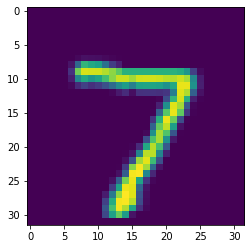

Original => Polar


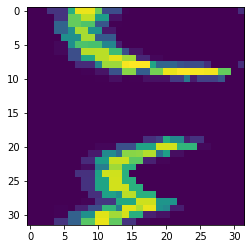

Rotated Original


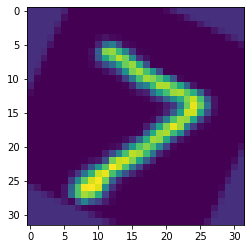

Rotated Original => Polar


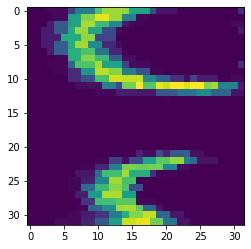

Cyclic Padding


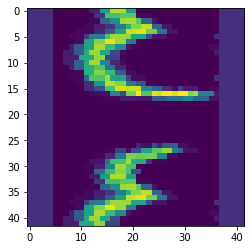

In [10]:
# -------------------------------------------
# EXAMPLE OF POLAR TRANSFORMATION AND PADDING
# -------------------------------------------

_, example_data = load_data('MNIST')
example_iter = iter(example_data)

for i in range(1):
    image, label = example_iter.next()
    print('Data label:', label[0], '\nOriginal Data')
    plt.imshow(np.transpose(image[0].numpy(), (1, 2, 0)))
    plt.show()
    
    print('Original => Polar')
    new_image = image.clone()
    new_image = polar_transform(new_image)
    plt.imshow(np.transpose(new_image[0].numpy(), (1, 2, 0)))
    plt.show()
    
    print('Rotated Original')
    image = random_rotate(image)
    plt.imshow(np.transpose(image[0].numpy(), (1, 2, 0)))
    plt.show()
    
    print('Rotated Original => Polar')
    new_image = image.clone()
    new_image = polar_transform(new_image)
    plt.imshow(np.transpose(new_image[0].numpy(), (1, 2, 0)))
    plt.show()
    
    print('Cyclic Padding')
    N = 5
    new_image = F.pad(new_image, (0, 0, N, N), mode='circular')
    new_image = F.pad(new_image, (N, N, 0, 0), mode='constant')
    plt.imshow(np.transpose(new_image[0].numpy(), (1, 2, 0)))

In [31]:
# ------------
# DEFINE CyCNN
# ------------

set_seed()

class CyNet(nn.Module):
    def __init__(self, layers=None, data='MNIST', random_rotate=False):
        '''
        `layers` can be passed to create a 'custom' CyCNN.
        layers should be a tuple (C, L), with:
            C => a list containing a triplet (INPUT_CHANNELS, OUTPUT_CHANNELS, KERNEL_SIZE) for each convolutional layer
            L => a list containing a tuple (INPUT_CHANNELS, OUTPUT_CHANNELS) for each linear layer
        
        `data` can be passed to indicate which default network to use.
        
        `random_rotate` can be used to make the network generalize better.
        However, there are some data requirements for it to work, which is why it is disabled by default.
        '''
        super().__init__()
        
        # Create Cyclic padding
        self.padVer = lambda x: F.pad(x, (0, 0, 1, 1), mode='circular')
        self.padHor = lambda x: F.pad(x, (1, 1, 0, 0), mode='constant')

        # Define the pooling used
        self.pool = nn.MaxPool2d(2, 2)
        
        # Create lists used for the convolutional- and linear layers.
        self.convs = nn.ModuleList()
        self.fcs = nn.ModuleList()
        self.view = -1
        
        self.random_rotate = random_rotate
        
        if layers is None:
            # If no layers are passed, create the default network
            # The default network is dependent on the data set
            if data == 'MNIST':
                # Default network for MNIST dataset
                self.convs.append(nn.Conv2d(1, 3, 3))
                self.convs.append(nn.Conv2d(3, 8, 3))
                self.convs.append(nn.Conv2d(8, 16, 3))
                self.convs.append(nn.Conv2d(16, 32, 3))
                self.convs.append(nn.Conv2d(32, 64, 3))

                self.view = 64

                self.fcs.append(nn.Linear(64, 32))
                self.fcs.append(nn.Linear(32, 24))
                self.fcs.append(nn.Linear(24, 10))

            if data == 'CAP':
                # Default network for CAP dataset
                self.convs.append(nn.Conv2d(3, 4, 3))
                self.convs.append(nn.Conv2d(4, 6, 3))
                self.convs.append(nn.Conv2d(6, 12, 3))
                self.convs.append(nn.Conv2d(12, 16, 3))
                self.convs.append(nn.Conv2d(16, 24, 3))

                self.view = 24

                self.fcs.append(nn.Linear(24, 12))
                self.fcs.append(nn.Linear(12, NUM_CLASSES_CAP))
                
                #self.convs.append(nn.Conv2d(3, 8, 3))
                #self.convs.append(nn.Conv2d(8, 16, 3))
                #self.convs.append(nn.Conv2d(16, 24, 3))
                #self.convs.append(nn.Conv2d(24, 32, 3))
                #self.convs.append(nn.Conv2d(32, 64, 3))

                #self.view = 64

                #self.fcs.append(nn.Linear(64, 32))
                #self.fcs.append(nn.Linear(32, 16))
                #self.fcs.append(nn.Linear(16, 8))
        else:
            # Parse the given layers
            for cl in layers[0]:
                self.convs.append(nn.Conv2d(cl[0], cl[1], cl[2]))
            for fcl in layers[1]:
                self.fcs.append(nn.Linear(fcl[0], fcl[1]))
            self.view = layers[1][0][0]

    def forward(self, x):
        if self.random_rotate:
            # Randomly rotate the input data is the option is enabled.
            x = random_rotate(x)
        # Perform polar transformation on the input
        x = polar_transform(x)
        # Run the sample through all convolutional layers
        for conv in self.convs:
            x = self.pool(F.relu(conv(self.padVer(self.padHor(x)))))
        # Run the result from the convolution through the linear layers
        x = x.view(-1, self.view)
        for l in self.fcs[:-1]:
            x = F.relu(l(x))
        # Don't use the relu for the last layer
        x = self.fcs[-1](x)
        return x

In [32]:
# ------------------------------------
# DEFINE EQUIVALENT CNN FOR COMPARISON
# ------------------------------------

set_seed()

class CNN(nn.Module):
    def __init__(self, layers=None, data='MNIST', random_rotate=False):
        '''
        `layers` can be passed to create a 'custom' CNN.
        layers should be a tuple (C, L), with:
            C => a list containing a triplet (INPUT_CHANNELS, OUTPUT_CHANNELS, KERNEL_SIZE) for each convolutional layer
            L => a list containing a tuple (INPUT_CHANNELS, OUTPUT_CHANNELS) for each linear layer
        
        `data` can be passed to indicate which default network to use.
        
        `random_rotate` can be used to make the network generalize better.
        However, there are some data requirements for it to work, which is why it is disabled by default.
        '''
        super().__init__()
        
        # Create zero padding
        self.padVer = lambda x: F.pad(x, (0, 0, 1, 1), mode='constant')
        self.padHor = lambda x: F.pad(x, (1, 1, 0, 0), mode='constant')
        
        # Define the pooling used
        self.pool = nn.MaxPool2d(2, 2)
        
        # Create lists used for the convolutional- and linear layers.
        self.convs = nn.ModuleList()
        self.fcs = nn.ModuleList()
        self.view = -1
        
        self.random_rotate = random_rotate
        
        if layers is None:
            # If no layers are passed, create the default network
            # The default network is dependent on the data set
            if data == 'MNIST':
                # Default network for MNIST dataset
                self.convs.append(nn.Conv2d(1, 3, 3))
                self.convs.append(nn.Conv2d(3, 8, 3))
                self.convs.append(nn.Conv2d(8, 16, 3))
                self.convs.append(nn.Conv2d(16, 32, 3))
                self.convs.append(nn.Conv2d(32, 64, 3))

                self.view = 64

                self.fcs.append(nn.Linear(64, 32))
                self.fcs.append(nn.Linear(32, 24))
                self.fcs.append(nn.Linear(24, 10))

            if data == 'CAP':
                # Default network for CAP dataset
                self.convs.append(nn.Conv2d(3, 4, 3))
                self.convs.append(nn.Conv2d(4, 6, 3))
                self.convs.append(nn.Conv2d(6, 12, 3))
                self.convs.append(nn.Conv2d(12, 16, 3))
                self.convs.append(nn.Conv2d(16, 24, 3))

                self.view = 24

                self.fcs.append(nn.Linear(24, 12))
                self.fcs.append(nn.Linear(12, NUM_CLASSES_CAP))
        else:
            # Parse the given layers
            for cl in layers[0]:
                self.convs.append(nn.Conv2d(cl[0], cl[1], cl[2]))
            for fcl in layers[1]:
                self.fcs.append(nn.Linear(fcl[0], fcl[1]))
            self.view = layers[1][0][0]

    def forward(self, x):
        if self.random_rotate:
            # Randomly rotate the input data is the option is enabled.
            x = random_rotate(x)
        # Run the sample through all convolutional layers
        for conv in self.convs:
            x = self.pool(F.relu(conv(self.padVer(self.padHor(x)))))
        # Run the result from the convolution through the linear layers
        x = x.view(-1, self.view)
        for l in self.fcs[:-1]:
            x = F.relu(l(x))
        # Don't use the relu for the last layer
        x = self.fcs[-1](x)
        return x

In [166]:
def train(net, data, epochs, lrs=[(0, 0.001), (1, 0.0001)], momentum=0.9, print_interval=2000, train_proportion=0.8):
    set_seed()
    
    train_loader, _ = load_data(data, train_proportion)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=momentum)
    
    #device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    device = "cpu"
    net.to(device)

    start_time = time.time()
    print("Started at: " + time.strftime("%H:%M:%S", time.localtime()))
    
    for epoch in range(epochs):  
        print('== Starting epoch ' + str(epoch) + ' ==')
        running_loss = 0.0
        
        for e, lr in lrs:
            if epoch == e:
                for g in optimizer.param_groups:
                    g['lr'] = lr

        for i, data in enumerate(train_loader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data[0].to(device), data[1].to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % print_interval == print_interval - 1:
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / print_interval))
                running_loss = 0.0

    print('Finished Training')
    elapsed_time = time.time() - start_time
    print('Finished Training in: ' + str(timedelta(seconds=elapsed_time)))

def test(net, data, test_proportion=0.2):
    set_seed()
    
    _, test_loader = load_data(data, test_proportion)
    device = "cpu"
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_loader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the', len(test_loader), 'test images: %d %%' % (
        100 * correct / total))

    correct = 0
    total = 0

    with torch.no_grad():
        for data in test_loader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = net(random_rotate(images))
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the', len(test_loader), 'randomly rotated test images: %d %%' % (
        100 * correct / total))

In [ ]:
cycnn_R = CyNet(data='MNIST', random_rotate=True)
train(cycnn_R, 'MNIST', 2, lrs=[(0, 0.001), (1, 0.0001)])

cycnn = CyNet(data='MNIST', random_rotate=False)
train(cycnn, 'MNIST', 2, lrs=[(0, 0.001), (1, 0.0001)])

cnn_R = CNN(data='MNIST', random_rotate=True)
train(cnn_R, 'MNIST', 2, lrs=[(0, 0.001), (1, 0.0001)])

cnn = CNN(data='MNIST', random_rotate=False)
train(cnn, 'MNIST', 2, lrs=[(0, 0.001), (1, 0.0001)])

In [ ]:
print('== CyCNN Rotated Training ==')
test(cycnn_R, 'MNIST')

print('== CyCNN Normal Training ==')
test(cycnn, 'MNIST')

print('== CNN Rotated Training ==')
test(cnn_R, 'MNIST')

print('== CNN Normal Training ==')
test(cnn, 'MNIST')

In [ ]:
# -------------------------------------------
# TEST CNN AND CYCNN ON FULL BEER CAP DATASET
# -------------------------------------------

cycnn_R = CyNet(data='CAP', random_rotate=True)
train(cycnn_R, 'CAP', 10, lrs=[(0, 0.001), (5, 0.0001)], momentum=0.9, print_interval=500)

cycnn = CyNet(data='CAP', random_rotate=False)
train(cycnn, 'CAP', 10, lrs=[(0, 0.001), (5, 0.0001)], momentum=0.9, print_interval=500)

cnn_R = CNN(data='CAP', random_rotate=True)
train(cnn_R, 'CAP', 10, lrs=[(0, 0.001), (5, 0.0001)], momentum=0.9, print_interval=500)

cnn = CNN(data='CAP', random_rotate=False)
train(cnn, 'CAP', 10, lrs=[(0, 0.001), (5, 0.0001)], momentum=0.9, print_interval=500)

Started at: 16:41:39
== Starting epoch 0 ==
[1,   500] loss: 1.387
[1,  1000] loss: 1.386
[1,  1500] loss: 1.386
[1,  2000] loss: 1.308
[1,  2500] loss: 1.165
[1,  3000] loss: 1.108
[1,  3500] loss: 1.012
[1,  4000] loss: 0.913
[1,  4500] loss: 0.816
== Starting epoch 1 ==
[2,   500] loss: 0.774
[2,  1000] loss: 0.635
[2,  1500] loss: 0.960
[2,  2000] loss: 0.916
[2,  2500] loss: 0.804
[2,  3000] loss: 0.714
[2,  3500] loss: 0.609
[2,  4000] loss: 0.578
[2,  4500] loss: 0.459
== Starting epoch 2 ==
[3,   500] loss: 0.437
[3,  1000] loss: 0.403
[3,  1500] loss: 0.422
[3,  2000] loss: 0.404
[3,  2500] loss: 0.365
[3,  3000] loss: 0.353
[3,  3500] loss: 0.339
[3,  4000] loss: 0.302
[3,  4500] loss: 0.250
== Starting epoch 3 ==
[4,   500] loss: 0.304
[4,  1000] loss: 0.219
[4,  1500] loss: 0.175
[4,  2000] loss: 0.244
[4,  2500] loss: 0.228
[4,  3000] loss: 0.185
[4,  3500] loss: 0.187
[4,  4000] loss: 0.179
[4,  4500] loss: 0.161
== Starting epoch 4 ==
[5,   500] loss: 0.135
[5,  1000] lo

In [ ]:
print('== CyCNN Rotated Training ==')
test(cycnn_R, 'CAP')

print('== CyCNN Normal Training ==')
test(cycnn, 'CAP')

print('== CNN Rotated Training ==')
test(cnn_R, 'CAP')

print('== CNN Normal Training ==')
test(cnn, 'CAP')

In [ ]:
data_usage = [0.8, 0.6, 0.4, 0.2]


for data_proportion in data_usage:

    cycnn = CyNet(data='CAP', random_rotate=False)
    train(cycnn, 'CAP', 10, lrs=[(0, 0.001), (5, 0.0001)], momentum=0.9, print_interval=500, train_proportion=data_proportion)
    test(cycnn, 'CAP')
    
    cnn = CNN(data='CAP', random_rotate=False)
    train(cnn, 'CAP', 10, lrs=[(0, 0.001), (5, 0.0001)], momentum=0.9, print_interval=500, train_proportion=data_proportion)
    test(cnn, 'CAP')